In [1]:
import sys
sys.path.insert(0,"/home/shackste/galaxy-generator/python_modules/")

import matplotlib.pyplot as plt

plt.style.use('dark_background')

from pdb import set_trace

# Classifier

In [2]:
import torch
from torch.nn import Module, Linear, MaxPool1d
from torch import max, Tensor
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torch.nn.modules.utils import _pair

from additional_layers import Reshape, PrintShape


class MaxOut(Module):
    """ Maxout Layer
    """
    def __init__(self, in_features: int, out_features: int, N_layers=2, **kwargs):
        super(MaxOut, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.dense = []
        for i, N_label in enumerate(label_group_sizes):
            layer = f"dense{i}"
            setattr(self, layer,
                Sequential(
                   Linear(self.in_features, self.out_features, **kwargs),
                )
            )
            self.dense.append( getattr(self, layer) )
        
        
    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.dense[0](input)
        for layer in self.dense[1:]:
            x = max(x, layer(input))
        return x

class MaxOut(Module):
    """ Maxout Layer
    """
    def __init__(self, in_features: int, out_features: int, N_layers=2, **kwargs):
        super(MaxOut, self).__init__()
        self.maxout = Sequential(
            Linear(in_features, N_layers*out_features, **kwargs),
            Reshape(1,N_layers*out_features),
            MaxPool1d(N_layers),
            Reshape(out_features),
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.maxout(x)
        return x

    
class Conv2dUntiedBias(Module):
    """
    2D Convolutional Layer with untied bias, i. e. individual trainable bias for each output pixel and feature
    
    Parameter
    ---------
    height(int) : height of output pixel map
    width(int) : width of output pixel map
    in_channels(int) : number of input channels
    out_channels(int) : number of output channels
    bias_init(float) : initial value for biases
    weight_std(float) : normal standard deviation for initial weights
    """
    def __init__(self, height: int, width: int, in_channels: int, out_channels: int, kernel_size: int,
                 stride=1, padding=0, dilation=1, groups=1, bias_init=0.1, weight_std=0.01):
        super(Conv2dUntiedBias, self).__init__() 
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)

        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        self.weight = Parameter(Tensor(
                out_channels, in_channels // groups, *kernel_size))
        self.bias = Parameter(Tensor(out_channels, height, width))
        self.reset_parameters(bias_init=bias_init, weight_std=weight_std)

    def reset_parameters(self, bias_init=None, weight_std=None) -> None:
        n = self.in_channels
        for k in self.kernel_size:
            n *= k
        if weight_std is None:
            stdv = n**-0.5
            self.weight.data.uniform_(-stdv, stdv)
        else:
            self.weight.data.uniform_(-weight_std, weight_std)            
        if bias_init is None:
            self.bias.data.uniform_(-stdv, stdv)
        else:
            self.bias.data[:] = bias_init
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if not self.kernel_size[0] % 2 and self.padding: ## one-sided padding 1 extra for even kernel size
            x = F.pad(input=x, pad=(1,0,1,0))
        output = F.conv2d(x, self.weight, None, self.stride,
                        self.padding, self.dilation, self.groups)
        # add untied bias
        output += self.bias.unsqueeze(0) #.repeat(input.size(0), 1, 1, 1)
        return output

    


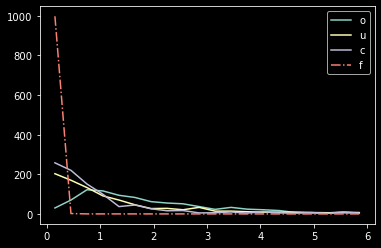

In [3]:
import numpy as np
import torch
from torch.nn import Conv2d

def diff(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    return torch.abs(torch.mean((a-b)/a)).item()

def plot_histo(d: list, **kwargs) -> None:
    h, x = np.histogram(d, range=(0,6), bins=20)
    x_plot = np.mean([x[:-1], x[1:]], axis=0)
    plt.plot(x_plot, h, **kwargs)

diffos, diffus, diffcs, difffs = [], [], [], []

cu = Conv2dUntiedBias(3,3,2,2,3, weight_std=None)
c = Conv2d(2, 2, 3)

for i in range(1000):
    r = torch.rand(2,2,5,5)
    
    diffos.append(diff(*r))
    diffus.append(diff(*cu(r)))
    diffcs.append(diff(*c(r)))
    difffs.append(diff(*F.conv2d(r, torch.randn(*cu.weight.shape)*0.01, None) + cu.bias.unsqueeze(0)))

plot_histo(diffos, label="o")
plot_histo(diffus, label="u")
plot_histo(diffcs, label="c")
plot_histo(difffs, label="f", ls="-.")
plt.legend()


In [4]:
import torchvision.models as models
import torch
from torch import squeeze, cat, stack
from torch.nn import Sequential, Linear, Conv2d, MaxPool2d, Softmax, Dropout, ReLU, Flatten, LeakyReLU
from torchvision.transforms import Compose, RandomHorizontalFlip, FiveCrop, Lambda, RandomErasing
from torchvision.transforms.functional import rotate, hflip
from torch.optim import SGD
from torch.optim.lr_scheduler import ExponentialLR

from neuralnetwork import NeuralNetwork
from labeling import make_galaxy_labels_hierarchical, label_group_sizes, labels_dim
from parameter import parameter

from dataset import augment

resnet = models.resnet18(pretrained=False)
N_resnet = 512

optimizer = SGD
optimizer_kwargs = {"nesterov":True, "momentum":0.9}
learning_rate_init = 0.0002
gamma = 0.9 # learning rate decay factor


class ImageClassifier(NeuralNetwork):
    def __init__(self, seed=None):
        super(ImageClassifier, self).__init__()
        if seed is not None:
            torch.manual_seed(seed)

        #'''
        self.conv = Sequential(
            *(list(resnet.children())[:-1]),
            Flatten(),
        )
        '''
        self.conv = Sequential(
#            Conv2dUntiedBias(41, 41, 3, 32, kernel_size=6),
            Conv2d(3,32, kernel_size=6),
            ReLU(),
            MaxPool2d(2),
#            Conv2dUntiedBias(16, 16, 32, 64, kernel_size=5),
            Conv2d(32, 64, kernel_size=5),
            ReLU(),
            MaxPool2d(2),
#            Conv2dUntiedBias(6, 6, 64, 128, kernel_size=3),
            Conv2d(64, 128, kernel_size=3),
            ReLU(),
#            Conv2dUntiedBias(4, 4, 128, 128, kernel_size=3), #weight_std=0.1),
            Conv2d(128, 128, kernel_size=3),
            ReLU(),
            MaxPool2d(2),
            Flatten(),
        )
        #'''
#        self.dense1 = Linear(8192, 2048, bias=0.01)
#        self.dense2 = Linear(2048, 2048, bias=0.01)
        self.dense1 = MaxOut(8192, 2048, bias=0.01) 
        self.dense2 = MaxOut(2048, 2048, bias=0.01) 
        self.dense3 = Sequential(
            MaxOut(2048, 37, bias=0.1),
#            Linear(2048, 37, bias=0.1),
            LeakyReLU(negative_slope=1e-8)
#            ReLU()
        )
        self.dropout = Dropout(p=0.5)
        
        self.augment = Compose([
            Lambda(lambda img: cat([img, hflip(img)], 0)),
            Lambda(lambda img: cat([img, rotate(img, 45)], 0)),
            FiveCrop(45),
            Lambda(lambda crops: cat([rotate(crop, ang) for crop, ang in zip(crops[:-1], (0, 90, 270, 180))], 0)),
        ])
        self.random_eraser = RandomErasing(scale=(0.01, 0.2))
        self.N_augmentations = 16
        self.N_conv_outputs = 512

        self.set_optimizer(optimizer, lr=learning_rate_init, **optimizer_kwargs)
        self.scheduler = ExponentialLR(self.optimizer, gamma=gamma)
        
        self.make_labels_hierarchical = False # if True, output probabilities are renormalized to fit the hierarchical label structure
        
        ## return to random seed
        if seed is not None:
            sd = np.random.random()*10000
            torch.manual_seed(sd)


    def update_optimizer(self, **kwargs) -> None:
        self.set_optimizer(optimizer, **kwargs)
        
    def update_optimizer_learningrate(self, learning_rate) -> None:
        print("update lr", learning_rate)
        for i in range(len(self.optimizer.param_groups)):
            self.optimizer.param_groups[i]['lr'] = learning_rate
        
    def use_label_hierarchy(self) -> None:
        self.make_labels_hierarchical = True
        
    def forward(self, x: torch.Tensor, train=False) -> torch.Tensor:
        batch_size = x.size(0)
        if train and False:
            x = self.random_eraser(x)
        x = self.augment(x)
        x = self.conv(x)

        ## combine results of augmentations to a single vector 
        x = x.reshape(self.N_augmentations, batch_size, self.N_conv_outputs)
        x = x.permute(1,0,2)
        x = x.reshape(batch_size, self.N_augmentations*self.N_conv_outputs)
                
        x = squeeze(x)        
        if train:
            x = self.dropout(x)
        x = self.dense1(x)
        if train:
            x = self.dropout(x)
        x = self.dense2(x)
        if train:
            x = self.dropout(x)
        x = self.dense3(x)
        x += 1e-6  ## use only with LeakyReLU to prevent values < 0
        if self.make_labels_hierarchical:
            x = make_galaxy_labels_hierarchical(x)
        return x

'''
from torch import rand
classifier = ImageClassifier()
img = rand(2, 3, 64, 64)
classifier(img).shape
'''

classifier = ImageClassifier()
r = torch.rand(6,3,45,45)
classifier.conv(r)


!!!!!!!!!!

galaxyzoo_data_cropped_nonnormalized.npy and training_solutions_rev1.csv must be placed in google drive under galaxy-generator/data/
the results will be placed there, too.



/home/shackste/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([[1.0181, 0.6338, 1.1722,  ..., 0.3229, 0.6433, 0.3343],
        [1.4102, 0.9533, 0.7104,  ..., 1.1714, 0.8137, 1.4999],
        [0.7862, 0.8962, 0.8973,  ..., 0.7995, 1.0473, 0.7660],
        [0.9383, 0.8642, 0.0215,  ..., 0.4579, 1.1876, 0.4000],
        [1.0472, 0.6880, 1.7674,  ..., 1.1133, 0.7255, 0.8936],
        [0.8448, 1.3012, 0.9884,  ..., 1.1163, 0.6931, 1.1406]],
       grad_fn=<ViewBackward>)

In [5]:
pytorch_total_params = sum([p.numel() for p in classifier.parameters()])
print(f"{pytorch_total_params:.2e} parameters, {pytorch_total_params * 32 /1024**3:.4} GB")

5.33e+07 parameters, 1.588 GB


In [6]:
import torch
from functools import partial

from labeling import class_groups_indices
from loss import mse


def measure_mse_accuracy_classifier_group(labels_prediction: torch.Tensor, labels_target: torch.Tensor,
                                          minimum_answers=0.5, allowed_deviation=0.1) -> torch.Tensor:
    """
    measure accuracy of classifier prediction. Calculates MSE loss on single label group
    where at least miminum_answers of people answered this question
    
    Parameters
    ----------
    labels_prediction(torch.tensor) : labels predicted by classifier
    labels_target(torch.tensor) : original labels
    minimum_answer(float) : (0.0 to 1.0) minimum amount of collected answers on a question to be considered
    """
    consider = torch.sum(labels_target, dim=1) > minimum_answers
    deviation = torch.abs(labels_prediction[consider] / labels_target[consider] - 1)
    nans = torch.isnan(deviation)
    deviation[nans] = torch.abs(labels_prediction[consider][nans] - labels_target[consider][nans])
    accuracy = torch.mean((deviation < allowed_deviation).float()).item()
#    accuracy = torch.mean((allowed_deviation > torch.abs(labels_prediction[consider] - labels_target[consider])).float()).item()
    return accuracy #if not torch.isnan(accuracy) else 0


def measure_accuracy_classifier_group(labels_prediction: torch.Tensor, labels_target: torch.Tensor,
                                      minimum_answers=0.5, allowed_deviation=0.1) -> torch.Tensor:
    """
    measure accuracy of classifier prediction for individual group. 
    for questions answered by at least miminum_answers of people
    return relative amount of agreements for maxed label
    
    Parameters
    ----------
    labels_prediction(torch.tensor) : labels predicted by classifier
    labels_target(torch.tensor) : original labels
    minimum_answer(float) : (0.0 to 1.0) minimum amount of collected answers on a question to be considered
    """
    consider = torch.sum(labels_target, dim=1) > minimum_answers
    pred = torch.argmax(labels_prediction[consider], dim=1)
    targ = torch.argmax(labels_target[consider], dim=1)
    accuracy = torch.mean((pred == targ).float()).item()
    return accuracy

def measure_accuracy_classifier(labels_prediction: torch.Tensor, labels_target: torch.Tensor,
                                minimum_answers=0.5, allowed_deviation=0.1, considered_groups=range(1,12)) -> torch.Tensor:
    """
    measure accuracy of classifier prediction. Calculates accuracy on label groups
    where at least miminum_answers of people answered this question
    returns loss for each group
    
    Parameters
    ----------
    labels_prediction(torch.tensor) : labels predicted by classifier
    labels_target(torch.tensor) : original labels
    minimum_answer(float) : (0.0 to 1.0) minimum amount of collected answers on a question to be considered
    """
    measure_accuracy = partial(measure_accuracy_classifier_group, minimum_answers=minimum_answers, allowed_deviation=allowed_deviation)
    accuracies = {group:measure_accuracy(labels_prediction[:,ix], labels_target[:,ix]) for group, ix in class_groups_indices.items() if group in considered_groups}
    return accuracies


    
    
def get_sample_variance(sample: torch.Tensor) -> torch.Tensor:
    """ calculate variance of sample via MSE from mean"""
    avg = torch.mean(sample, dim=0, keepdims=True)
    sample_variance = mse(sample, avg.repeat(len(sample), *(1,)*(sample.dim()-1)))
    return sample_variance
    
def loss_sample_variance(features: torch.Tensor, threshold=0.001) -> torch.Tensor:
    """ calculate loss of sample variance as mean squared error from average """
    sample_variance = get_sample_variance(features)
    loss = torch.max(torch.tensor(0).to(device), threshold - sample_variance)
    return loss
    
def plot_losses(losses: list, steps: int, iteration: int, label=None) -> None:
#    iterations = list(range(0, iteration+1, steps))
    iterations = torch.arange(len(losses)) * steps
    plt.plot(iterations, losses, label=label)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.xlabel("iteration")


# Training

In [7]:
from time import time
from math import ceil
from functools import partial
from collections import Counter

import torch 

from loss import mse
from dataset import MakeDataLoader
from neuralnetwork import update_networks_on_loss
from labeling import class_group_layers

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#if device == torch.device("cuda"):
#    torch.cuda.empty_cache()

optimizer = SGD
optimizer_kwargs = {"nesterov":True, "momentum":0.9}
learning_rate_init = 0.04
gamma = 0.995 # learning rate decay factor
sample_variance_threshold = 0.002
seed_parameter = 7

weight_loss_sample_variance = 0 # 10.

epochs = 1000 #500 #100  #  433 epochs done by Dielemann et al. 2015

batch_size = 32

considered_groups = set() ## container for set of groups to be considered in training and evaluation
considered_layers_init = [1, 2, 3, 4, 5][:4]  ## group layers to be considered from start
considered_label_indices = []

def consider_groups(groups: set, considered_groups=considered_groups) -> None:
    """ add group to considered_groups """
    considered_groups.update(groups)
    
def consider_layer(layer: int) -> None:
    """ add groups in layer to considered_groups """
    consider_groups(class_group_layers[layer])
    
def update_considered_label_indices(considered_groups=considered_groups, 
                                    considered_label_indices=considered_label_indices) -> None:
    """ find label indices of groups to be considered """
    for group, indices in class_groups_indices.items():
        if group in considered_groups:
            for ix in indices:
                if not ix in considered_label_indices:
                    considered_label_indices.append(ix)
    considered_label_indices.sort()
            
def add_considered_layer(layer: int) -> None:
    """ add layer to considered layers and update considered label indices """
    consider_layer(layer)
    update_considered_label_indices()

for layer in considered_layers_init:
    add_considered_layer(layer)
    
considered_label_indices.remove(9) ## Question 9 is not modeled well

make_data_loader = MakeDataLoader()
classifier = ImageClassifier(seed=seed_parameter).to(device)

classifier.load()
classifier.use_label_hierarchy()


schedule = {
    # epoch : performed change
    2 : classifier.use_label_hierarchy,
}

losses = []
losses_steps = 250  # number of batches between loss tracking
print_losses_steps = float("inf") #2000 # float("inf") for no prints
batch_size_test = batch_size
N_test_batch_full = 1024
N_batches_test = 1 #ceil(N_test_batch_full / batch_size_test)
train_sample_variances = []

test_losses = []
test_losses_steps = 250 # number of batches after which to measure test loss and accuracy
print_test_losses_steps = float("inf") #2000 # float("inf") for no prints 
accuracy = []
accuracies = {g:[] for g in range(1,12)}
sample_variances = []


iteration = 1
epoch = 1

In [8]:
print(device)
torch.cuda.is_available(), classifier.make_labels_hierarchical, considered_groups
#data_loader_train.num_workers


cuda


(True, True, {1, 2, 3, 4, 5, 6, 7, 9})

epoch 1: 100%|██████████| 1731/1731 [07:40<00:00,  3.76it/s]


tensor([ 4.5373e-01,  5.4627e-01, -4.1557e-11,  1.2662e-01,  4.1965e-01,
         1.5985e-09,  4.1965e-01,  2.0836e-01,  2.1129e-01,  1.8646e-01,
         1.8119e-01,  1.1142e-10,  2.3110e-01,  7.6890e-01,  1.7859e-01,
         2.1204e-01,  6.3107e-02,  7.8029e-02,  8.9933e-11,  4.8591e-02],
       device='cuda:0')
tensor([0.1655, 0.8192, 0.0153, 0.0166, 0.8025, 0.4002, 0.4024, 0.2058, 0.5967,
        0.0965, 0.5676, 0.1384, 0.7261, 0.2739, 0.0433, 0.1222, 0.0000, 0.0166,
        0.0000, 0.0000], device='cuda:0')
tensor([ 2.8823e-01, -2.7291e-01, -1.5322e-02,  1.0999e-01, -3.8290e-01,
        -4.0020e-01,  1.7296e-02,  2.5373e-03, -3.8544e-01,  8.9943e-02,
        -3.8646e-01, -1.3839e-01, -4.9497e-01,  4.9497e-01,  1.3529e-01,
         8.9836e-02,  6.3107e-02,  6.1397e-02,  8.9933e-11,  4.8591e-02],
       device='cuda:0')

tensor([ 4.5374e-01,  5.4626e-01, -5.2943e-11,  1.2670e-01,  4.1956e-01,
         1.3817e-09,  4.1956e-01,  2.0836e-01,  2.1120e-01,  1.8639e-01,
         1.8112e-

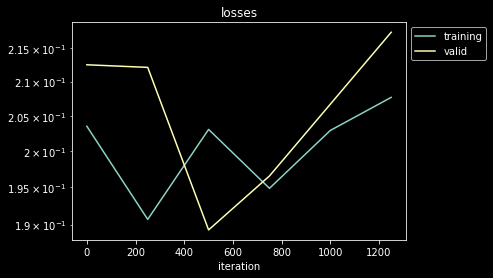

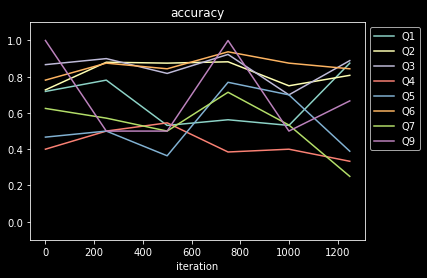

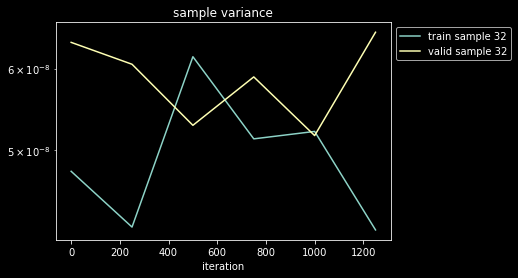

epoch 2: 100%|██████████| 1731/1731 [07:38<00:00,  3.78it/s]


tensor([ 4.5989e-01,  5.4011e-01, -6.7294e-11,  1.2743e-01,  4.1268e-01,
         1.1170e-09,  4.1268e-01,  2.0273e-01,  2.0994e-01,  1.7890e-01,
         1.8187e-01,  8.0567e-11,  2.3635e-01,  7.6365e-01,  1.8029e-01,
         2.1651e-01,  6.3088e-02,  7.8227e-02,  7.0916e-11,  4.9206e-02],
       device='cuda:0')
tensor([0.7111, 0.2537, 0.0352, 0.1269, 0.1269, 0.0000, 0.1269, 0.0000, 0.1269,
        0.1269, 0.0000, 0.0000, 0.0698, 0.9302, 0.0000, 0.4023, 0.3088, 0.1269,
        0.0000, 0.0000], device='cuda:0')
tensor([-2.5120e-01,  2.8639e-01, -3.5190e-02,  5.7471e-04,  2.8582e-01,
         1.1170e-09,  2.8582e-01,  2.0273e-01,  8.3085e-02,  5.2044e-02,
         1.8187e-01,  8.0567e-11,  1.6651e-01, -1.6651e-01,  1.8029e-01,
        -1.8575e-01, -2.4574e-01, -4.8631e-02,  7.0916e-11,  4.9206e-02],
       device='cuda:0')

tensor([ 4.6050e-01,  5.3950e-01, -6.4621e-11,  1.2761e-01,  4.1190e-01,
         1.1629e-09,  4.1190e-01,  2.0222e-01,  2.0967e-01,  1.7854e-01,
         1.8141e-

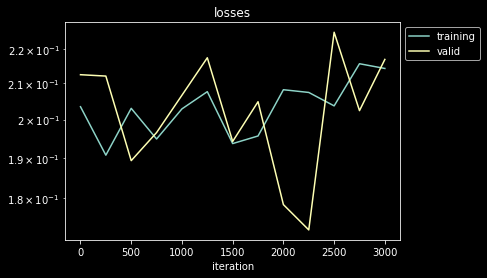

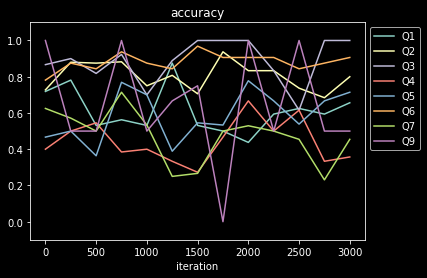

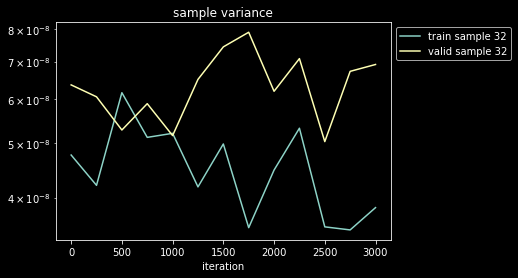

epoch 3: 100%|██████████| 1731/1731 [07:40<00:00,  3.76it/s]


tensor([ 4.5540e-01,  5.4460e-01, -8.4585e-11,  1.2594e-01,  4.1866e-01,
         7.9405e-10,  4.1866e-01,  2.0680e-01,  2.1187e-01,  1.8582e-01,
         1.8143e-01,  6.2435e-11,  2.3290e-01,  7.6710e-01,  1.7449e-01,
         2.1663e-01,  6.4283e-02,  7.8282e-02,  5.7067e-11,  4.7654e-02],
       device='cuda:0')
tensor([0.4898, 0.4795, 0.0307, 0.0000, 0.4795, 0.1638, 0.3158, 0.1785, 0.3011,
        0.2651, 0.2145, 0.0000, 0.3118, 0.6882, 0.4114, 0.0784, 0.0000, 0.0000,
        0.0000, 0.0000], device='cuda:0')
tensor([-3.4401e-02,  6.5053e-02, -3.0652e-02,  1.2594e-01, -6.0882e-02,
        -1.6379e-01,  1.0290e-01,  2.8336e-02, -8.9219e-02, -7.9236e-02,
        -3.3061e-02,  6.2435e-11, -7.8871e-02,  7.8871e-02, -2.3693e-01,
         1.3824e-01,  6.4283e-02,  7.8282e-02,  5.7067e-11,  4.7654e-02],
       device='cuda:0')

tensor([ 4.5522e-01,  5.4478e-01, -4.0635e-11,  1.2629e-01,  4.1849e-01,
         1.6009e-09,  4.1849e-01,  2.0683e-01,  2.1166e-01,  1.8571e-01,
         1.8125e-

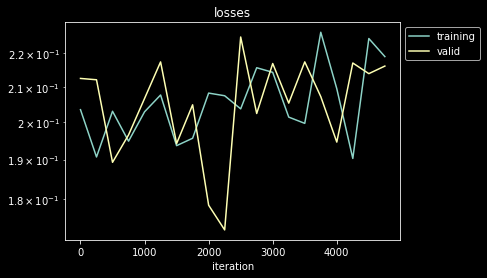

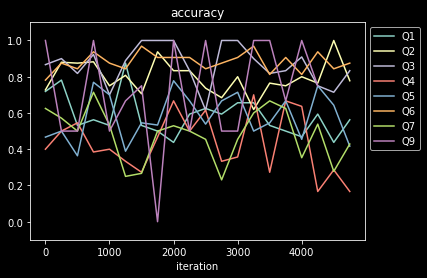

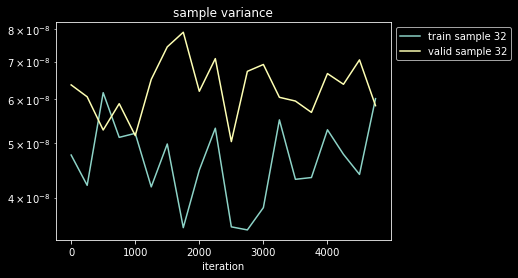

epoch 4: 100%|██████████| 1731/1731 [07:34<00:00,  3.81it/s]


tensor([ 4.5618e-01,  5.4382e-01, -4.7473e-11,  1.2983e-01,  4.1398e-01,
         1.4515e-09,  4.1398e-01,  2.0646e-01,  2.0753e-01,  1.8677e-01,
         1.7576e-01,  1.0252e-10,  2.2629e-01,  7.7371e-01,  1.7636e-01,
         2.1554e-01,  6.4281e-02,  7.9935e-02,  8.6222e-11,  4.9900e-02],
       device='cuda:0')
tensor([0.1867, 0.8020, 0.0112, 0.0419, 0.7601, 0.1392, 0.6209, 0.4304, 0.3298,
        0.3337, 0.2470, 0.1365, 0.5078, 0.4922, 0.0000, 0.1867, 0.0000, 0.0419,
        0.0000, 0.0000], device='cuda:0')
tensor([ 2.6944e-01, -2.5821e-01, -1.1226e-02,  8.7947e-02, -3.4616e-01,
        -1.3925e-01, -2.0691e-01, -2.2390e-01, -1.2225e-01, -1.4697e-01,
        -7.1202e-02, -1.3655e-01, -2.8149e-01,  2.8149e-01,  1.7636e-01,
         2.8796e-02,  6.4281e-02,  3.8047e-02,  8.6222e-11,  4.9900e-02],
       device='cuda:0')

tensor([ 4.5619e-01,  5.4381e-01, -4.1287e-11,  1.2972e-01,  4.1409e-01,
         1.5719e-09,  4.1409e-01,  2.0644e-01,  2.0764e-01,  1.8683e-01,
         1.7582e-

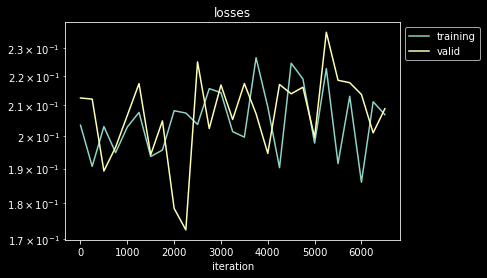

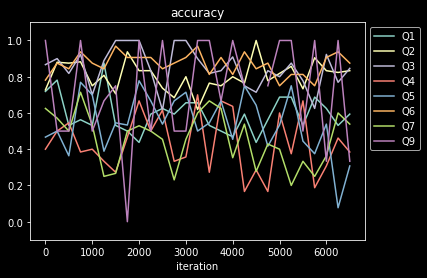

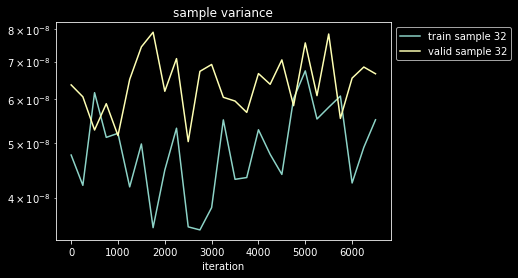

epoch 5: 100%|██████████| 1731/1731 [07:32<00:00,  3.82it/s]


tensor([ 4.6550e-01,  5.3450e-01, -5.2710e-11,  1.2797e-01,  4.0653e-01,
         1.3184e-09,  4.0653e-01,  1.9835e-01,  2.0818e-01,  1.7727e-01,
         1.7656e-01,  9.3903e-11,  2.3460e-01,  7.6540e-01,  1.8328e-01,
         2.1879e-01,  6.3433e-02,  7.8530e-02,  7.9928e-11,  4.9439e-02],
       device='cuda:0')
tensor([0.0611, 0.9389, 0.0000, 0.0461, 0.8928, 0.0490, 0.8438, 0.7888, 0.1039,
        0.3117, 0.5416, 0.0395, 0.2481, 0.7519, 0.0390, 0.0221, 0.0000, 0.0461,
        0.0000, 0.0000], device='cuda:0')
tensor([ 4.0442e-01, -4.0442e-01, -5.2710e-11,  8.1820e-02, -4.8624e-01,
        -4.8961e-02, -4.3728e-01, -5.9048e-01,  1.0424e-01, -1.3438e-01,
        -3.6509e-01, -3.9471e-02, -1.3526e-02,  1.3526e-02,  1.4425e-01,
         1.9674e-01,  6.3433e-02,  3.2381e-02,  7.9928e-11,  4.9439e-02],
       device='cuda:0')

tensor([ 4.6544e-01,  5.3456e-01, -7.1785e-11,  1.2736e-01,  4.0720e-01,
         1.0143e-09,  4.0720e-01,  1.9851e-01,  2.0868e-01,  1.7769e-01,
         1.7705e-

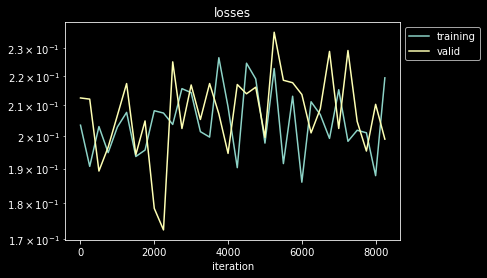

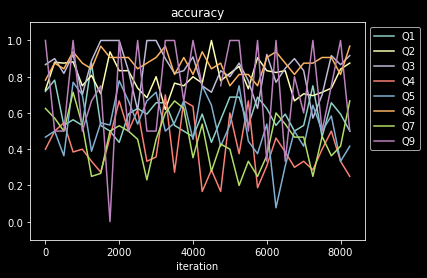

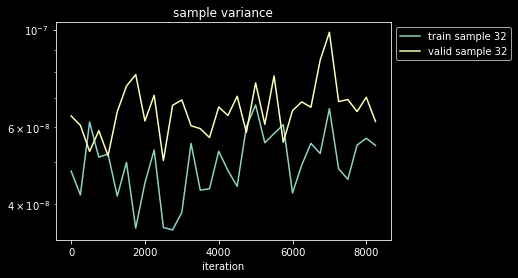

epoch 6: 100%|██████████| 1731/1731 [08:02<00:00,  3.59it/s]


tensor([ 4.5841e-01,  5.4159e-01, -4.0136e-11,  1.3274e-01,  4.0885e-01,
         1.5474e-09,  4.0885e-01,  2.0216e-01,  2.0669e-01,  1.7832e-01,
         1.7749e-01,  1.0824e-10,  2.2950e-01,  7.7050e-01,  1.7774e-01,
         2.1518e-01,  6.5496e-02,  8.1277e-02,  9.2951e-11,  5.1464e-02],
       device='cuda:0')
tensor([1.3697e-02, 9.8447e-01, 1.8330e-03, 0.0000e+00, 9.8447e-01, 3.7180e-01,
        6.1267e-01, 9.8447e-01, 0.0000e+00, 8.3779e-01, 0.0000e+00, 0.0000e+00,
        2.7430e-01, 7.2570e-01, 7.8100e-04, 1.2916e-02, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00], device='cuda:0')
tensor([ 4.4472e-01, -4.4288e-01, -1.8330e-03,  1.3274e-01, -5.7562e-01,
        -3.7180e-01, -2.0382e-01, -7.8231e-01,  2.0669e-01, -6.5947e-01,
         1.7749e-01,  1.0824e-10, -4.4801e-02,  4.4801e-02,  1.7696e-01,
         2.0226e-01,  6.5496e-02,  8.1277e-02,  9.2951e-11,  5.1464e-02],
       device='cuda:0')

tensor([ 4.5840e-01,  5.4160e-01, -2.2200e-11,  1.3223e-01,  4.0937e-01,
  

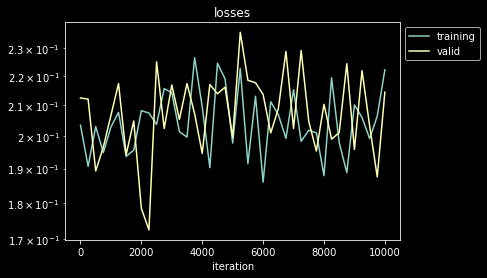

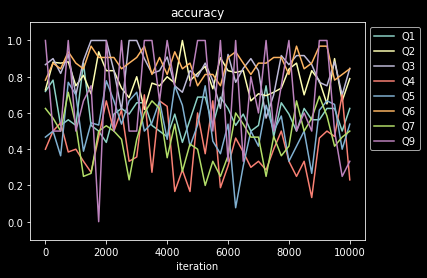

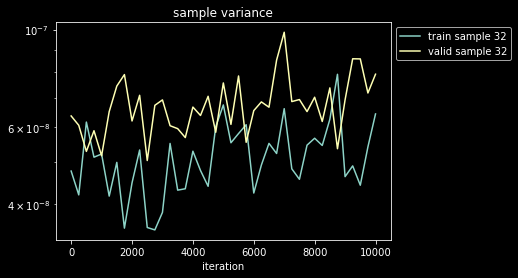

epoch 7:  24%|██▍       | 414/1731 [02:03<06:42,  3.27it/s]

In [ ]:
import gc
from math import sqrt
from tqdm import tqdm

from file_system import root

epoch = 1

t0 = time()

data_loader_test = []

while epoch < epochs+1:
    ## adjust training according to schedule
    if epoch in schedule.keys():
        schedule[epoch]()
    data_loader_train = make_data_loader.get_data_loader_train(batch_size=batch_size) #, num_workers=4)
    for images, labels in tqdm(data_loader_train, desc=f"epoch {epoch}"):
#    for images, labels in data_loader_train:
        if not iteration % test_losses_steps:
            if not len(data_loader_test) > N_batches_test:
                data_loader_test = make_data_loader.get_data_loader_valid(batch_size=batch_size_test) #, num_workers=4)
#                data_loader_test = make_data_loader.get_data_loader_train(batch_size=batch_size_test, num_workers=4)
            with torch.no_grad():
                loss = 0
                accs = Counter({group:0 for group in range(1,12)})
                variance = 0
                for N_test, (images_test, labels_test) in enumerate(data_loader_test):
                    if N_test >= N_batches_test:
                        break                        
                    images_test = images_test.to(device)
                    labels_test = labels_test.to(device)
                    labels_pred = classifier(images_test)
                    loss += mse(labels_pred[:,considered_label_indices], labels_test[:,considered_label_indices]).item()
                    loss += weight_loss_sample_variance * loss_sample_variance(labels_pred[:,considered_label_indices], threshold=sample_variance_threshold).item()
                    accs_tmp = measure_accuracy_classifier(labels_pred, labels_test, considered_groups=considered_groups)
                    accs.update(Counter(accs_tmp))
                    variance += get_sample_variance(labels_pred).item()
                for group, acc in accs.items():
                    accuracies[group].append(acc / N_batches_test)
                loss /= N_batches_test
                variance /= N_batches_test
                
                if not iteration % print_test_losses_steps:
                    print(f"test loss {loss:.4}, {iteration} iterations")
                test_losses.append(sqrt(loss))
                sample_variances.append(variance)

                del images_test, labels_test, labels_pred, loss
                
        images = images.to(device)
        labels = labels.to(device)
        
        labels_pred = classifier(images, train=True)
        loss = mse(labels_pred[:,considered_label_indices], labels[:,considered_label_indices])
        loss += weight_loss_sample_variance * loss_sample_variance(labels_pred[:,considered_label_indices], threshold=sample_variance_threshold)
        update_networks_on_loss(loss, classifier)
            
        if not iteration % losses_steps:
            losses.append(sqrt(loss.item()))
            train_sample_variances.append(get_sample_variance(labels_pred[:,considered_label_indices]).item())
        if not iteration % print_losses_steps:
            t1 = time()
            print(f"training loss {loss.item():.4}, iteration {iteration+1}, {t1-t0:.3} s")
            t0 = t1
        del images, labels, labels_pred, loss

        iteration += 1        
    epoch += 1
    
        
#        if not iteration % 3: # == 400:
#            break
    with torch.no_grad():
        for images, labels in make_data_loader.get_data_loader_train(batch_size=batch_size, num_workers=4):
            images = images.to(device)
            labels = labels.to(device)
            labels_pred = classifier(images)
            break

        for pred, targ in zip(labels_pred[:3], labels[:3]):
            print(pred[considered_label_indices])
            print(targ[considered_label_indices])
            print(pred[considered_label_indices]-targ[considered_label_indices])
            print()
        
        del images, labels, labels_pred

    classifier.scheduler.step()
    classifier.save()
    plot_losses(losses, losses_steps, iteration, label="training")
    plot_losses(test_losses, test_losses_steps, iteration, label="valid")
    plt.title("losses")
    plt.yscale("log")
    plt.show()
    
    plt.title("accuracy")
    for group, accuracy in accuracies.items():
        if not group in considered_groups:
            continue
        plot_losses(accuracy, test_losses_steps, iteration, label=f"Q{group}")
    plt.ylim(-0.1,1.1)
    plt.show()
    
    plt.title("sample variance")
    plot_losses(train_sample_variances, losses_steps, iteration, label=f"train sample {batch_size}")
    plot_losses(sample_variances, test_losses_steps, iteration, label=f"valid sample {N_batches_test*batch_size_test}")
    plt.yscale("log")
    plt.show()


In [ ]:
for label in labels_pred:
    print(label)

In [ ]:
for group, accuracy in accuracies.items():
    if not group in considered_groups:
        continue
    plt.title("accuracy")
    plot_losses(accuracy, test_losses_steps, iteration, label=f"Q{group}")
    plt.ylim(-0.1,1.1)
    plt.show()

In [ ]:
N_aug = 16
N_batch = 3

with torch.no_grad():
    for images, labels in make_data_loader.get_data_loader_train(batch_size=batch_size, num_workers=4):
        images = images.to(device)
        labels = labels.to(device)
        break


imgs = classifier.augment(images)
shp = imgs.shape
print(imgs.shape, images.shape)
imgs = imgs.reshape(N_aug, N_batch,*shp[1:])
imgs = imgs.permute(1,0,2,3,4)
imgs = imgs.reshape(N_aug*N_batch,*shp[1:])
print(imgs.shape)

#for image, l in zip(imgs, classifier(images)):
#    print(l)
for image in imgs:
    plt.imshow(image.permute(1,2,0).cpu())
    plt.show()


In [ ]:
for g in classifier.optimizer.param_groups:
    print(g["lr"])

In [ ]:
with torch.no_grad():
    data_loader_test = make_data_loader.get_data_loader_train(batch_size=batch_size_test, num_workers=4)
    loss = 0
    accs = Counter({group:0 for group in range(1,12)})
    for N_test, (images_test, labels_test) in enumerate(data_loader_test):
        images_test = images_test.to(device)
        labels_test = labels_test.to(device)
        labels_pred = classifier(images_test)
        loss += mse(labels_pred, labels_test).item()
        accs_tmp = measure_accuracy_classifier(labels_pred, labels_test)
        accs.update(Counter(accs_tmp))
        if N_test == N_batches_test:
            break                        
        break
print(accs)
print(accs[1])
for i in range(len(labels_test)):   
    print("predic", labels_pred[i,:3])
    print("target", labels_test[i,:3])
    print("diff  ", labels_test[i,:3] - labels_pred[i,:3])
    
    print()
    

In [ ]:
print(iteration, len(test_losses), test_losses_steps)
plot_losses(losses, losses_steps, iteration, label="training")
plot_losses(test_losses, test_losses_steps, iteration, label="test")
plt.show()
        

In [ ]:
ll = torch.rand(2,37)
make_galaxy_labels_hierarchical(ll)

## Interpretation of sample variance

In [ ]:
N_batch, N_feat = 32, 3
m = torch.rand(1,N_feat)
differences = [0.0001,0.001, 0.01, 0.1, 1]
var = []
for d in differences:
    sample = m + d*torch.randn(N_batch,N_feat)
    var.append(get_sample_variance(sample))
plt.loglog(differences, var)
plt.xlabel("average difference")
plt.ylabel("sample variance")

the sample variance is about the squared average difference: sample variance of $10^{-4}$ refers to mean difference of 1%